In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
import os
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import matplotlib.patches as patches
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def get_model_names_cmip6(path):
    names = []
    files = path#glob.glob(path)
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[1]
        names.append(model)
    return names

In [4]:
def get_model_names_cmip5(path):
    names = []
    files = path#glob.glob(path)
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[2]
        names.append(model)
    return names

In [22]:
def cmip_prep(y):
    
    cmip_dic = {'id': [], 'Ensemble' : [], 'Model name' : [], 'TCW | shear': [], 'Daily p95' : [], 'BC Daily p95' : [], '3-hourly p95' : []}

  
    cmip5_tcw_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_'+str(y)+'/prw_*.nc')  
    cmip6_tcw_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_'+str(y)+'/CMIP6_*.nc')
    
    
    cmip6_rainfall_day = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_'+str(y)+'/CMIP6_*_day_*.nc')
    cmip6_dayrain_names = get_model_names_cmip6(cmip6_rainfall_day)
    
    cmip6_rainfall_hour = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_'+str(y)+'/CMIP6_*_3hr_*.nc')
    cmip6_hourrain_names = get_model_names_cmip6(cmip6_rainfall_hour)
    
    cmip5_rainfall_day = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/pr_diff_'+str(y)+'/pr_day_*.nc')
    cmip5_dayrain_names = get_model_names_cmip5(cmip5_rainfall_day)
    
    cmip5_rainfall_bc = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/pr_diff_'+str(y)+'/pr_WFDEI_*.nc')
    cmip5_bcrain_names = get_model_names_cmip5(cmip5_rainfall_bc)

    cnt = 0
    for cmi in cmip6_tcw_files:

        fn = os.path.basename(cmi).split('_')
        model_name = fn[1]
        
        if model_name == 'CMCC-CM2-SR5':
            continue
        
        cnt += 1
        
        cmip_dic['id'].append(cnt)
        cmip_dic['Ensemble'].append(fn[0])
        
        cmip_dic['Model name'].append(fn[1])
        cmip_dic['TCW | shear'].append('x')
        cmip_dic['BC Daily p95'].append('')
        p95day = ''
        p95hour = ''

        if model_name in cmip6_dayrain_names:
            p95day = 'x'
            
        if model_name in cmip6_hourrain_names:
            p95hour = 'x'
            
        cmip_dic['Daily p95'].append(p95day)
        cmip_dic['3-hourly p95'].append(p95hour)
        
            
            
    for cmi in cmip5_tcw_files:

        fn = os.path.basename(cmi).split('_')
        
        cnt += 1
        
        cmip_dic['id'].append(cnt)
        cmip_dic['Ensemble'].append('CMIP5')
        model_name = fn[2]
        cmip_dic['Model name'].append(fn[2])
        cmip_dic['TCW | shear'].append('x')
        cmip_dic['3-hourly p95'].append('')
        
        p95bc = ''
        p95day = ''
        
        if model_name in cmip5_bcrain_names:
            p95bc = 'x'
            
        if model_name in cmip5_dayrain_names:
            p95day = 'x'
            
        #ipdb.set_trace()
            
        cmip_dic['Daily p95'].append(p95day)          
        cmip_dic['BC Daily p95'].append(p95bc)




    return cmip_dic

In [23]:
cmip_dic = cmip_prep(2080)

In [24]:
df = pd.DataFrame(cmip_dic)
df = df.set_index('id')

In [25]:
df.to_latex()

'\\begin{tabular}{lllllll}\n\\toprule\n{} & Ensemble &       Model name & TCW | shear & Daily p95 & BC Daily p95 & 3-hourly p95 \\\\\nid &          &                  &             &           &              &              \\\\\n\\midrule\n1  &    CMIP6 &         GFDL-CM4 &           x &         x &              &              \\\\\n2  &    CMIP6 &       MRI-ESM2-0 &           x &         x &              &              \\\\\n3  &    CMIP6 &       ACCESS-CM2 &           x &         x &              &              \\\\\n4  &    CMIP6 &    AWI-CM-1-1-MR &           x &           &              &              \\\\\n5  &    CMIP6 &      BCC-CSM2-MR &           x &         x &              &            x \\\\\n6  &    CMIP6 &      CAMS-CSM1-0 &           x &           &              &              \\\\\n7  &    CMIP6 &          CanESM5 &           x &         x &              &              \\\\\n8  &    CMIP6 &      CESM2-WACCM &           x &         x &              &              \\\\\n

In [10]:
ds_merge = xr.merge([cmip_tcw_map, cmip_shear_map])

In [11]:
model_names = ds_merge.model_name

In [14]:
cmip_precip_files = ''

In [30]:
def prep_cmip_list(region):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip5_read = {}
    cmip_read = {}
    for dd in dics:
        cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP_'+region+'.csv', index_col='model_name')
        
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip6_read = {}
    for dd in dics:
        cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_'+region+'.csv', index_col='model_name')

    for dd in dics:
        cmip_read[dd[1]] = pd.concat([cmip5_read[dd[1]], cmip6_read[dd[1]]])
        cmip_read[dd[1]] = cmip_read[dd[1]].dropna()
    
    return cmip_read

In [31]:
def prep_cmip5_precip(region, tag):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
    dics = [('2070-2100', '2080')] #('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), 
    cmip5_read = {}
    cmip_read = {}
    if tag != 'RAW3h':
        for dd in dics:
            cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP_'+region+'.csv', index_col='model_name')

            cmip5_read[dd[1]] = cmip5_read[dd[1]].dropna()
            #cmip5_read[dd[1]] = (cmip5_read[dd[1]])[(cmip5_read[dd[1]])['pr_mean']>0]
    
    if tag == 'RAW':
        
        base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
        dics = [('2070-2100', '2080')]
        cmip6_read = {}
        for dd in dics:
            cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP6_'+region+'.csv', index_col='model_name')

        for dd in dics:
            cmip_read[dd[1]] = pd.concat([cmip5_read[dd[1]], cmip6_read[dd[1]]])
            cmip_read[dd[1]] = cmip_read[dd[1]].dropna()
            
    if tag == 'RAW3h':
        
        base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
        dics = [('2070-2100', '2080')]

        for dd in dics:
            cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_'+tag+'_CMIP6_'+region+'.csv', index_col='model_name')

            
    return cmip5_read, cmip_read

In [79]:
sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y ]

regions = {'bamako': (bamako, 'Bamako'), 'sahel':(sahel, 'Sahel'), 'ouaga':(ouaga, 'Ouagadougou'), 'niamey':(niamey, 'Niamey'), 'timbuktu':(timbuktu, 'Timbuktu'), 'dakar': (dakar, 'Dakar')}

all_cmip = []
all_cmip_list = []
all_cp4_scaled = []
tcw_cp4_scaled = []
all_cp4_raw = []
all_cp4_p95_grid = []
all_cmip5_raw = []
all_cmip5_bc = []
all_cmip5_3h = []
all_cmip5_3hequi = []
cp4_hist_rain = []

cp4_error_total = []
cp4_tcw_total = []

for idss, rname in enumerate(['sahel', 'bamako',  'timbuktu', 'niamey']):   #'ouaga',
#cp4f_mcs_grid-

    region = rname

    box = (regions[region])[0]
    city = (regions[region])[1]

    fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors_small.p', "rb"))
    ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factor_small.p', "rb"))

    shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
    tcwvfac_all =  np.array(ftcw['abs']) 

    dirs = regions

    cp4_tcw_diff = cp4_tcw_fut-cp4_tcw_hist
    cp4_tcw_diff = cp4_tcw_diff['tcwv'].sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3])).mean().squeeze()

    cp4_tcw_rel = (cp4_tcw_fut-cp4_tcw_hist)/cp4_tcw_hist


    cp4_shear_diff = cp4_shear_fut-cp4_shear_hist
    cp4_shear_diff = cp4_shear_diff.sel(longitude=slice(box[0], box[1]), latitude=slice(box[2], box[3])).mean().squeeze()
    
    cp4_mcs_diff_grid = (cp4f_mcs_grid - cp4_mcs_grid)/cp4_mcs_grid*100
    cp4_mcs_diff_grid = cp4_mcs_diff_grid.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).mean().squeeze()
    cp4_mcs_hist_grid = cp4_mcs_grid.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).mean().squeeze()

    yy = '2080'
    tcw_map, sh_map = cmip_prep(yy)
    ds_merge = xr.merge([tcw_map, sh_map])
    ds_merge = ds_merge.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean(['lat','lon']).squeeze()

    #ax.axhline(100, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'tcw' : [], 'shear' : [], 'total':[]}
    fdiclist = {'tcw' : [], 'shear' : [], 'total':[]}
    cpdic = {'tcw' : [], 'shear' : [], 'total':[]}

    cmip_list = prep_cmip_list(region)
    cmip_list = cmip_list[yy]
    
    cp4hist_mcs95, cp4fut_mcs95, obs_mcs95 = calc_mcs(box) 

    #mm_to_perc = (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'] /  (cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp']) *100
    mm_to_perc = np.mean(((ftcw['prcp_fut']-ftcw['prcp_hist'])/ ftcw['prcp_hist'])   / (ftcw['prcp_fut']-ftcw['prcp_hist']))*100
    print(mm_to_perc)
        
    tcwvfac = np.mean(tcwvfac_all)
    
    #####get CMIP raw hourly
    p_hourly_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')
    nouse, cmip_rainfall_3h = prep_cmip5_precip(region, 'RAW3h')
    cmip_rainfall_3h = cmip_rainfall_3h['2080']
    cmipr_out_3h = cmip_rainfall_3h['pr_mean'] / cmip_rainfall_3h['pr_hist'] * 100
    all_cmip5_3h.append(cmipr_out_3h)

    
    
    ####get CMIP raw daily
    cmip_rainfall, nouse = prep_cmip5_precip(region, 'BC')
    nouse, cmip_rainfall_R = prep_cmip5_precip(region, 'RAW')
    cmip_rainfall = cmip_rainfall['2080']
    cmip_rainfall_R = cmip_rainfall_R['2080']
    cmipr_out = cmip_rainfall['pr_mean'] / cmip_rainfall['pr_hist'] * 100
    cmipr_out_R = cmip_rainfall_R['pr_mean'] / cmip_rainfall_R['pr_hist'] * 100
    all_cmip5_bc.append(cmipr_out)
    all_cmip5_raw.append(cmipr_out_R)

    all_cmip5_3hequi.append(cmipr_out_R[p_hourly_names])
    
    #ipdb.set_trace()

    ###get CP4 raw hourly
    all_cp4_raw.append(((cp4fut_mcs95['prcp']-cp4hist_mcs95['prcp'])/cp4hist_mcs95['prcp'])*100) 
    all_cp4_p95_grid.append(cp4_mcs_diff_grid)
    cp4_hist_rain.append(cp4hist_mcs95['prcp'])
    
    cptcw = cp4_tcw_diff* tcwvfac
    cpshear = cp4_shear_diff['u_pl'] * shearfac
    cpdic['tcw'] = cptcw 
    cpdic['shear'] = cpshear
    cpdic['total'] = (cptcw+cpshear) * mm_to_perc #/cp4hist_mcs95['prcp']*100 #* mm_to_perc
    
    all_cp4_scaled.append((cpdic['total']))
    tcw_cp4_scaled.append(cpdic['tcw'] * mm_to_perc)  # 
    
    for fag, tcwvfac in zip(['min','max','mean'],[np.min(tcwvfac_all), np.max(tcwvfac_all), np.median(tcwvfac_all)]):

        if fag == 'mean':
            sfac = shearfac
        if fag == 'min':
            sfac = shearfac-shearSE
        if fag == 'max':
            sfac = shearfac+shearSE

        ds_shear = ds_merge['unknown']*sfac
        ds_tcw = (ds_merge['prw'].where(ds_merge['prw_hist']>21.5)) * tcwvfac #/ds_merge['prw_hist'])

        lds_shear = cmip_list['shear_mean'] * sfac
        lds_tcw = cmip_list['tcw_mean'] * tcwvfac
        
        #ipdb.set_trace()

        fdic['tcw']=ds_tcw
        fdic['shear'] = ds_shear
        fdic['total']= (ds_tcw+ds_shear) / cp4_mcs_hist_grid.values*100 #* mm_to_perc#/cp4hist_mcs95['prcp']*100#
        fdic['total'] = fdic['total'].where(np.isfinite(fdic['total']), drop=True)

        fdiclist['tcw']=lds_tcw, 
        fdiclist['shear'] = lds_shear
        fdiclist['total']= (lds_tcw+lds_shear)  / cp4_mcs_hist_grid.values*100 #* mm_to_perc # /cp4hist_mcs95['prcp']*100#* mm_to_perc

        all_cmip.append(np.array(fdic['total']))
        all_cmip_list.append(np.array(fdiclist['total']))
        
        #ipdb.set_trace()
        
        cptcw = cp4_tcw_diff* tcwvfac
        cpshear = cp4_shear_diff['u_pl'] * sfac
        cpdic['tcw'] = cptcw 
        cpdic['shear'] = cpshear
        cpdic['total'] = (cptcw+cpshear) * mm_to_perc #/cp4hist_mcs95['prcp']*100 #* mm_to_perc
        cp4_error_total.append(cpdic['total'])
        cp4_tcw_total.append(cpdic['tcw']* mm_to_perc)

2.4911090750810856
2.4911090750810856
2.4911090750810856
2.4911090750810856


In [ ]:
f = plt.figure(figsize=(18,7), dpi=200)
cnt=1
for pn in p_hourly_names:
    ax = f.add_subplot(2,2,cnt)
    
    ##1 
    testdiff = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_'+pn+'_ssp585_3hr_*.nc')[0])
    testhist = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/CMIP6_'+pn+'_historical_day_*.nc')[0])
    testfut = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/CMIP6_'+pn+'_ssp585_day_*.nc')[0])
    
    plt.scatter(testdiff['pr_hist'], testhist['pr'], color='blue')
    plt.scatter(testdiff['pr_hist']+testdiff['pr'], testfut['pr'], color='red', alpha=0.1)
    
    plt.plot(np.arange(0,0.003,0.001), np.arange(0,0.003,0.001), color='k')
    
    cnt +=1

In [56]:
p_hourly_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')

In [86]:
p_daily = []
p_hourly = []
lats = []
region='sahel'
box = (regions[region])[0]
box = [-10, 15, 8, 18]
for pn in p_hourly_names:
    
    ph = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/*'+pn+'_*_'+'3hr*')[0])
    pd = xr.open_dataset(glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/*'+pn+'_*_'+'day*')[0])

    ph = ph.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3]))
    pd = pd.sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3]))
    ph = ph.where((ph['pr_hist']+ph['pr'])<0.003)
    pd = pd.where((pd['pr_hist']+ph['pr'])<0.003)
    if (pn not in ph.model_name) | (pn not in pd.model_name):
        ipdb.set_trace()
        
    p_hourly.append((ph['pr']/ph['pr_hist']*100))
    p_daily.append((pd['pr']/pd['pr_hist']*100))

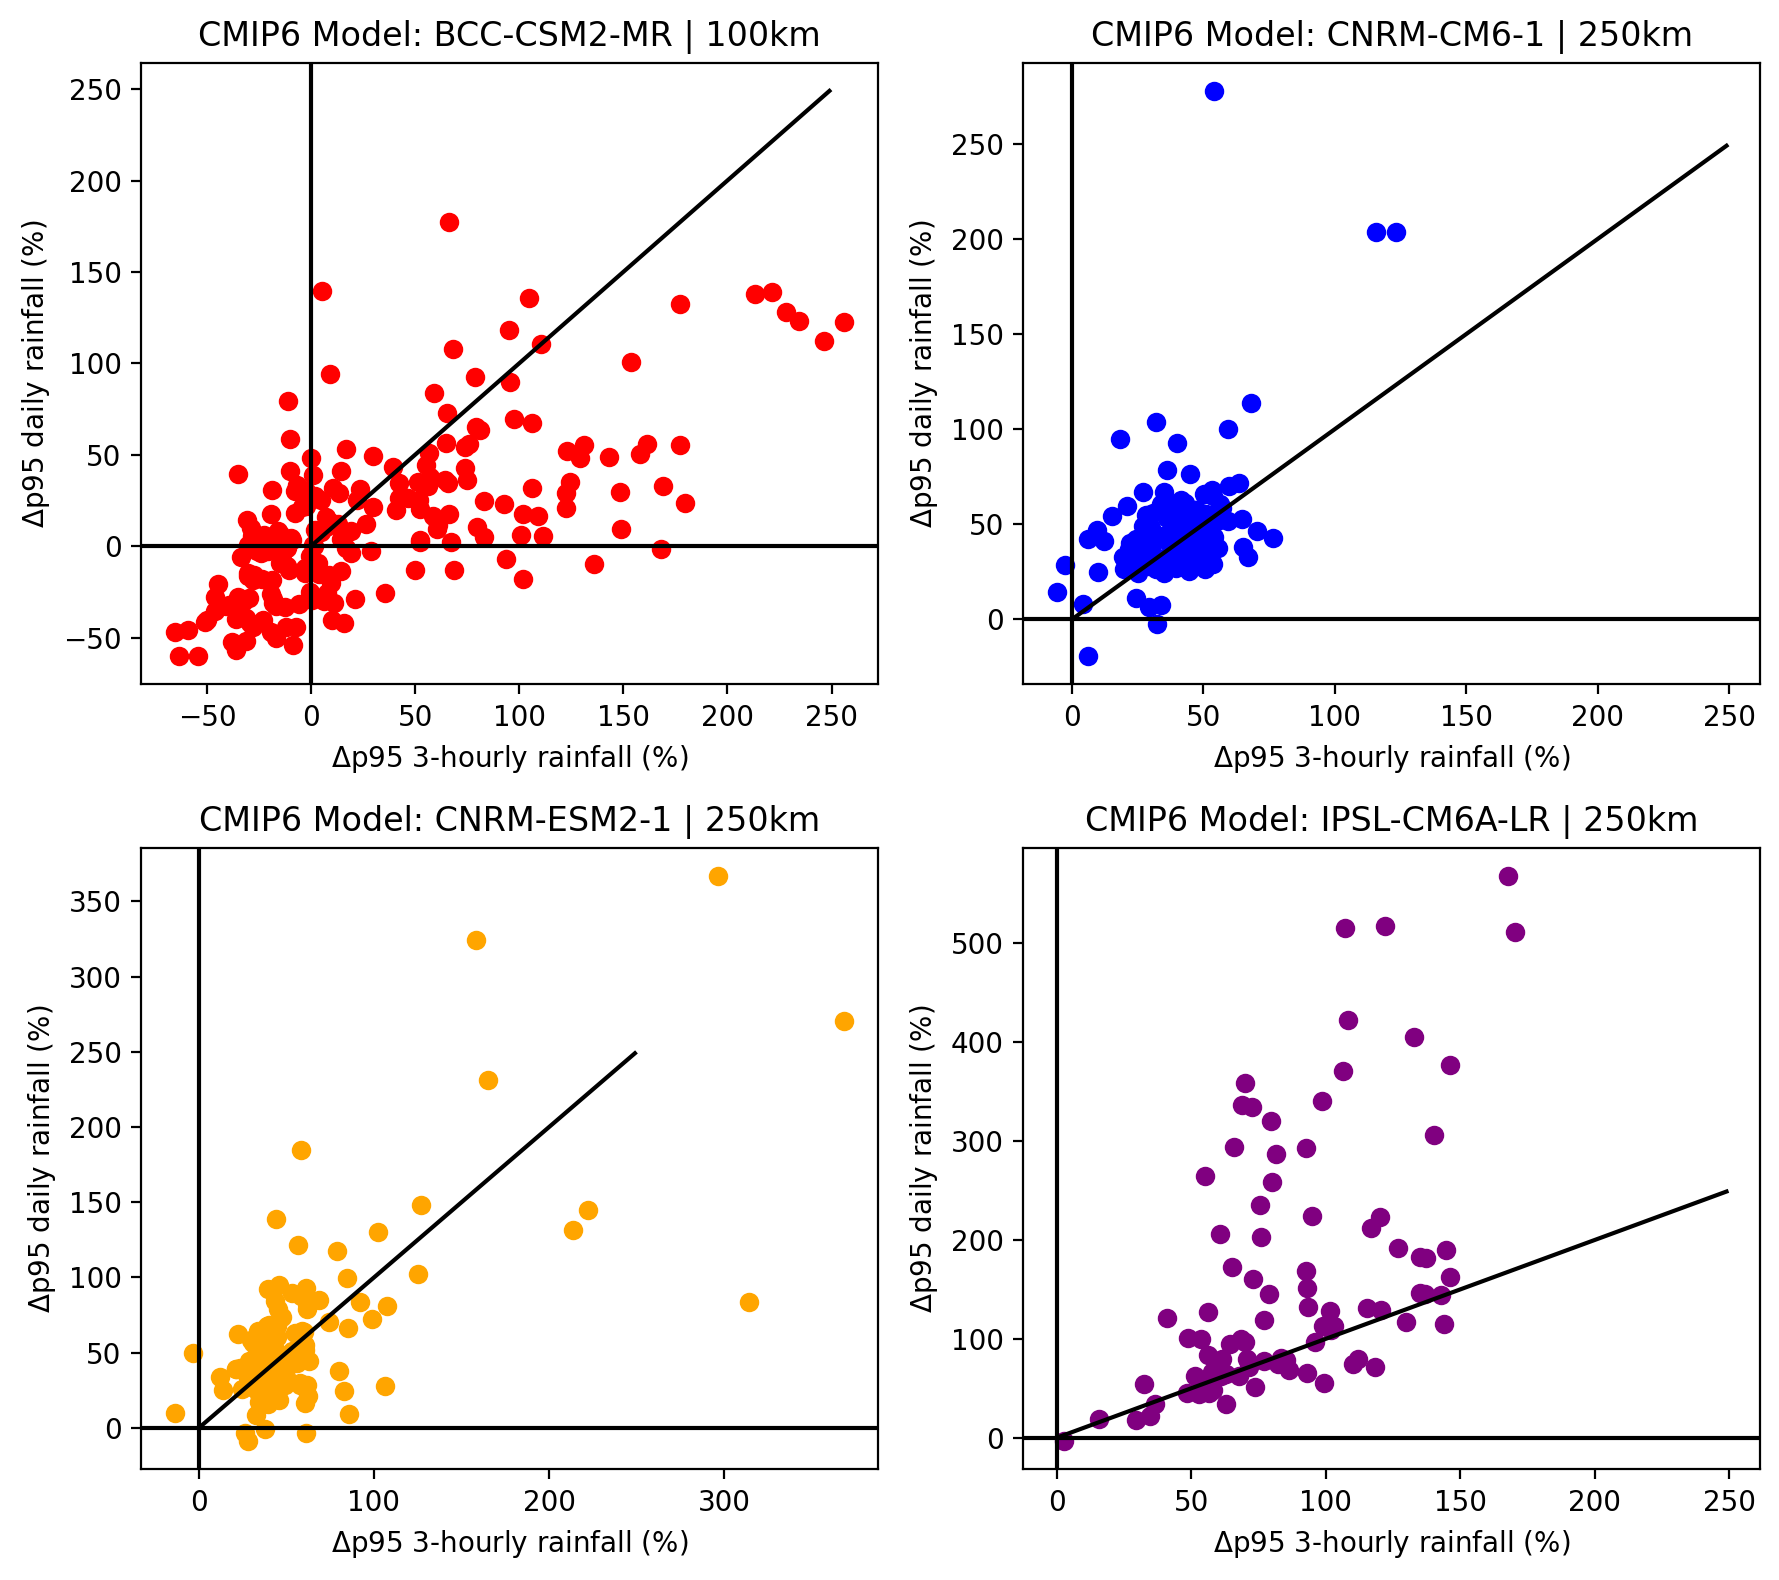

In [90]:
f = plt.figure(figsize=(9,8), dpi=200)
cnt=1
colors = ['r', 'b', 'orange', 'purple']
resos = ['100km', '250km', '250km', '250km']

for phh, pdd in zip(p_hourly, p_daily):
    ax = f.add_subplot(2,2,cnt)
    lati,loni = np.meshgrid(phh.lat, phh.lon)
    mp = ax.scatter(phh, pdd, color=colors[cnt-1])
    #plt.colorbar(mp)
    #ipdb.set_trace()

    ax.plot(np.arange(0,250), np.arange(0,250), color='k')
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    plt.title('CMIP6 Model: '+str(phh.model_name.values[0])+' | '+resos[cnt-1])
    plt.xlabel('$\Delta$p95 3-hourly rainfall (%)')
    plt.ylabel('$\Delta$p95 daily rainfall (%)')
    plt.axhline(0, color='k')
    plt.axvline(0, color='k')
    cnt+=1
    plt.tight_layout()
#     plt.xlim(-10,200)
#     plt.ylim(-10,400)
# f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/CMIP6_hourly_daily_scaling.jpg')